> __Purpose:__ This NB tests a CNN in the agglomerative model clustering procedure. With later finetuning. Uses the previously developed PyTorch code

In [1]:
model_str = "CNN"
# Train/test user split: 24/8


In [2]:
import pandas as pd
import pickle
import numpy as np
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import torch

np.random.seed(42) 

from moments_engr import *
from agglo_model_clust import *
from cluster_acc_viz_funcs import *
from DNN_FT_funcs import *
from DNN_AMC_funcs import *


In [3]:
path1 = 'C:\\Users\\kdmen\\Box\\Meta_Gesture_2024\\saved_datasets\\filtered_datasets\\$BStand_EMG_df.pkl'

with open(path1, 'rb') as file:
    raw_userdef_data_df = pickle.load(file)  # (204800, 19)

print(raw_userdef_data_df.shape)
raw_userdef_data_df.head()

(204800, 19)


,Participant,Gesture_ID,Gesture_Num,EMG1,EMG2,EMG3,EMG4,EMG5,EMG6,EMG7,EMG8,EMG9,EMG10,EMG11,EMG12,EMG13,EMG14,EMG15,EMG16
0,P102,pan,1,-0.362743,-0.801651,-0.383077,-0.195299,-0.203047,-0.464472,-0.276292,-0.026736,-0.873870,-1.036152,-0.580930,-0.719494,-0.502255,-1.750091,-0.127847,-0.094192
1,P102,pan,1,-0.351553,-0.775334,-0.382545,-0.154773,-0.131977,-0.295204,-0.125822,0.089679,-0.816215,-2.082635,-0.006283,-0.139439,-0.367764,-0.208084,-0.111811,-0.039009
2,P102,pan,1,-0.380825,-0.762588,-0.398388,-0.085411,0.017528,-0.205675,-0.068451,0.117076,-0.668221,-3.403064,-0.526030,-0.478294,-0.300443,0.203266,0.113300,0.004728
3,P102,pan,1,-0.366795,-0.765464,-0.374423,-0.073225,0.183172,0.009277,-0.058907,0.080977,-0.424416,-3.709413,-0.570894,-0.775155,-0.144710,-0.619539,0.146499,0.199975
4,P102,pan,1,-0.245578,-0.761283,-0.303976,-0.081947,0.224996,0.103319,-0.003929,0.041526,-0.016530,-4.075150,-0.127710,2.682791,-0.141750,-0.208404,-0.035642,0.172662


In [4]:
# STEP 1: Train a classification model on every single individual user

userdef_df = raw_userdef_data_df.groupby(['Participant', 'Gesture_ID', 'Gesture_Num']).apply(create_feature_vectors)
#output is df with particpant, gesture_ID, gesture_num and feature (holds 80 len vector)
userdef_df = userdef_df.reset_index(drop=True)

#convert Gesture_ID to numerical with new Gesture_Encoded column
label_encoder = LabelEncoder()
userdef_df['Gesture_Encoded'] = label_encoder.fit_transform(userdef_df['Gesture_ID'])

label_encoder2 = LabelEncoder()
userdef_df['Cluster_ID'] = label_encoder2.fit_transform(userdef_df['Participant'])

print(userdef_df.shape)
userdef_df.head()

(3200, 6)


,Participant,Gesture_ID,Gesture_Num,feature,Gesture_Encoded,Cluster_ID
0,P004,close,1,"[[6.079045311063784], [-7.551458873254243], [-...",0,0
1,P004,close,10,"[[5.994789910363704], [-7.978871468164499], [-...",0,0
2,P004,close,2,"[[6.010193380499154], [-7.7063875553339], [-20...",0,0
3,P004,close,3,"[[5.8212078257286874], [-7.463908156909893], [...",0,0
4,P004,close,4,"[[5.974675085061773], [-7.945111601415482], [-...",0,0


In [5]:
all_participants = userdef_df['Participant'].unique()
# Shuffle the participants
np.random.shuffle(all_participants)
# Split into two groups
#train_participants = all_participants[:24]  # First 24 participants
test_participants = all_participants[24:]  # Remaining 8 participants

In [6]:
# Prepare data
data_splits = prepare_data(
    userdef_df, 'feature', 'Gesture_Encoded', 
    all_participants, test_participants, 
    training_trials_per_gesture=8, finetuning_trials_per_gesture=3,
)

In [7]:
data_splits.keys()

dict_keys(['train', 'intra_subject_test', 'novel_trainFT', 'cross_subject_test'])

In [8]:
data_splits['train'].keys()

dict_keys(['feature', 'labels', 'participant_ids'])

In [9]:
features_df = pd.DataFrame(data_splits['train']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
train_df['Cluster_ID'] = label_encoder.fit_transform(train_df['participant_ids'])

features_df = pd.DataFrame(data_splits['intra_subject_test']['feature'])
# Create a new column 'features' that contains all 80 columns as lists
features_df['feature'] = features_df.apply(lambda row: row.tolist(), axis=1)
# Keep only the new combined column
features_df = features_df[['feature']]
# Combine with labels and participant_ids into a single DataFrame
test_df = pd.concat([features_df, pd.Series(data_splits['intra_subject_test']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['intra_subject_test']['participant_ids'], name='participant_ids')], axis=1)
label_encoder = LabelEncoder()
test_df['Cluster_ID'] = label_encoder.fit_transform(test_df['participant_ids'])

# ENTIRELY WITHHOLDING CROSS CLUSTER DATASET (NOVEL TEST SUBJECTS) FOR NOW. 
#test_df
#features_df = pd.DataFrame(data_splits['train']['features'])
## Create a new column 'features' that contains all 80 columns as lists
#features_df['features'] = features_df.apply(lambda row: row.tolist(), axis=1)
## Keep only the new combined column
#features_df = features_df[['features']]
## Combine with labels and participant_ids into a single DataFrame
#train_df = pd.concat([features_df, pd.Series(data_splits['train']['labels'], name='Gesture_Encoded'), pd.Series(data_splits['train']['participant_ids'], name='participant_ids')], axis=1)

In [10]:
data_dfs_dict = {'train':train_df, 'test':test_df}

# Need to update Cluster_ID col at the end of each round, for both dfs

In [11]:
train_df.head()

,feature,Gesture_Encoded,participant_ids,Cluster_ID
0,"[4.0728441780827485, -6.216633410388578, -15.0...",0,P128,22
1,"[4.842766138855771, -7.933026853320965, -18.38...",0,P128,22
2,"[4.343725560839635, -6.20391996380322, -15.560...",0,P128,22
3,"[4.972292120731378, -6.996600730998998, -17.60...",0,P128,22
4,"[4.942130684716379, -6.513267267205743, -16.81...",0,P128,22


In [12]:
merge_log, intra_cluster_performance, cross_cluster_performance, nested_clus_model_dict = DNN_agglo_merge_procedure(data_dfs_dict, model_str, n_splits=2)

Iter 0: 24 Clusters Remaining
Iter 1: 23 Clusters Remaining
Iter 2: 22 Clusters Remaining
Iter 3: 21 Clusters Remaining
Iter 4: 20 Clusters Remaining
Iter 5: 19 Clusters Remaining
Iter 6: 18 Clusters Remaining
Iter 7: 17 Clusters Remaining
Iter 8: 16 Clusters Remaining
Iter 9: 15 Clusters Remaining
Iter 10: 14 Clusters Remaining
Iter 11: 13 Clusters Remaining
Iter 12: 12 Clusters Remaining
Iter 13: 11 Clusters Remaining
Iter 14: 10 Clusters Remaining
Iter 15: 9 Clusters Remaining
Iter 16: 8 Clusters Remaining
Iter 17: 7 Clusters Remaining
Iter 18: 6 Clusters Remaining
Iter 19: 5 Clusters Remaining
Iter 20: 4 Clusters Remaining
Iter 21: 3 Clusters Remaining
Iter 22: 2 Clusters Remaining


In [13]:
merge_log

[(0, 5, 3, 0.35, 24),
 (1, 22, 10, 0.4, 25),
 (2, 0, 7, 0.3, 26),
 (3, 13, 17, 0.3, 27),
 (4, 2, 1, 0.35, 28),
 (5, 15, 20, 0.3, 29),
 (6, 6, 21, 0.35, 30),
 (7, 28, 8, 0.35, 31),
 (8, 4, 14, 0.25, 32),
 (9, 12, 26, 0.3, 33),
 (10, 29, 11, 0.3, 34),
 (11, 16, 23, 0.25, 35),
 (12, 19, 30, 0.325, 36),
 (13, 32, 24, 0.2, 37),
 (14, 31, 9, 0.2, 38),
 (15, 37, 25, 0.25, 39),
 (16, 39, 33, 0.16666666666666666, 40),
 (17, 35, 34, 0.16666666666666666, 41),
 (18, 40, 41, 0.16, 42),
 (19, 42, 27, 0.175, 43),
 (20, 18, 38, 0.1625, 44),
 (21, 43, 44, 0.12, 45),
 (22, 45, 36, 0.11666666666666667, 46)]

## INTRA CLUSTER RESULTS

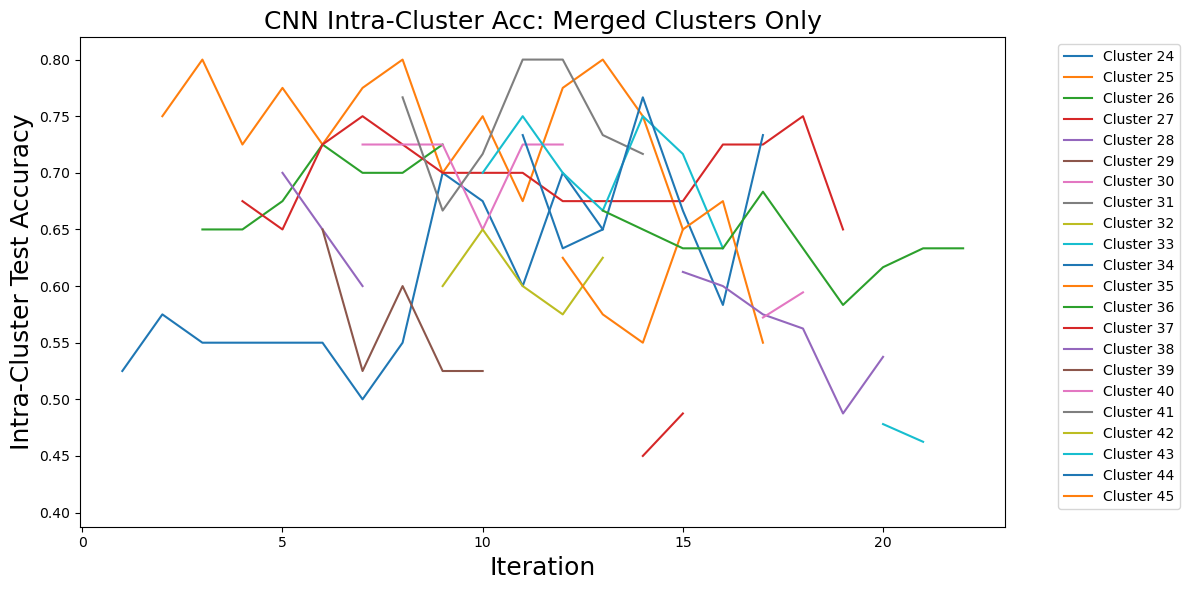

In [14]:
viz_merged_intracluster_acc(intra_cluster_performance, model_str)

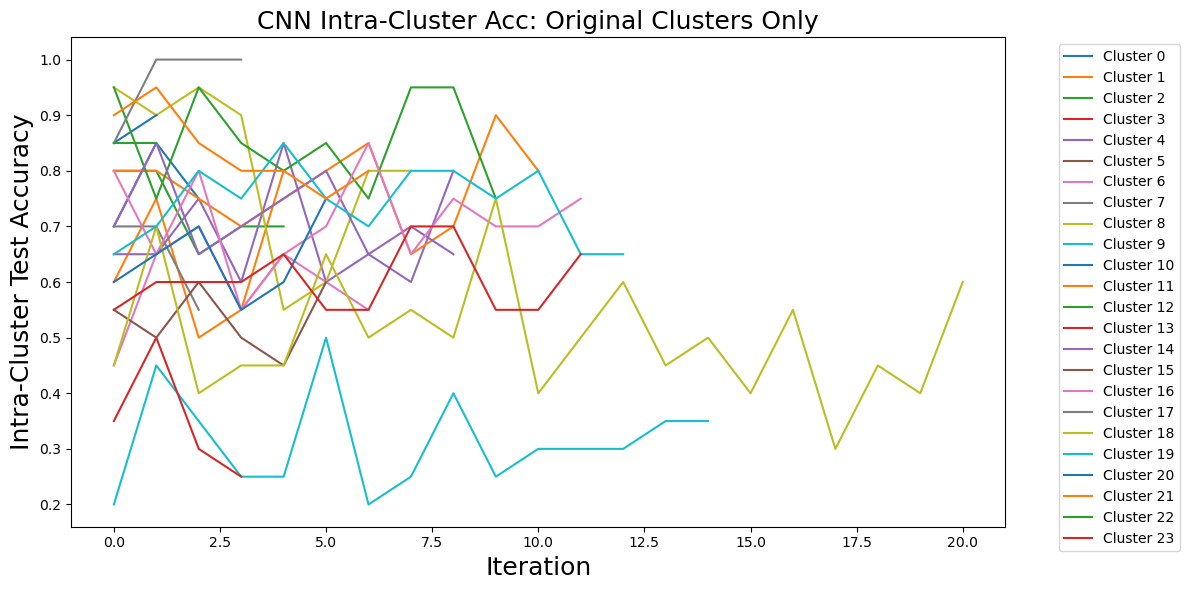

In [15]:
viz_orig_intracluster_acc(intra_cluster_performance, model_str)

## CROSS CLUSTER RESULTS

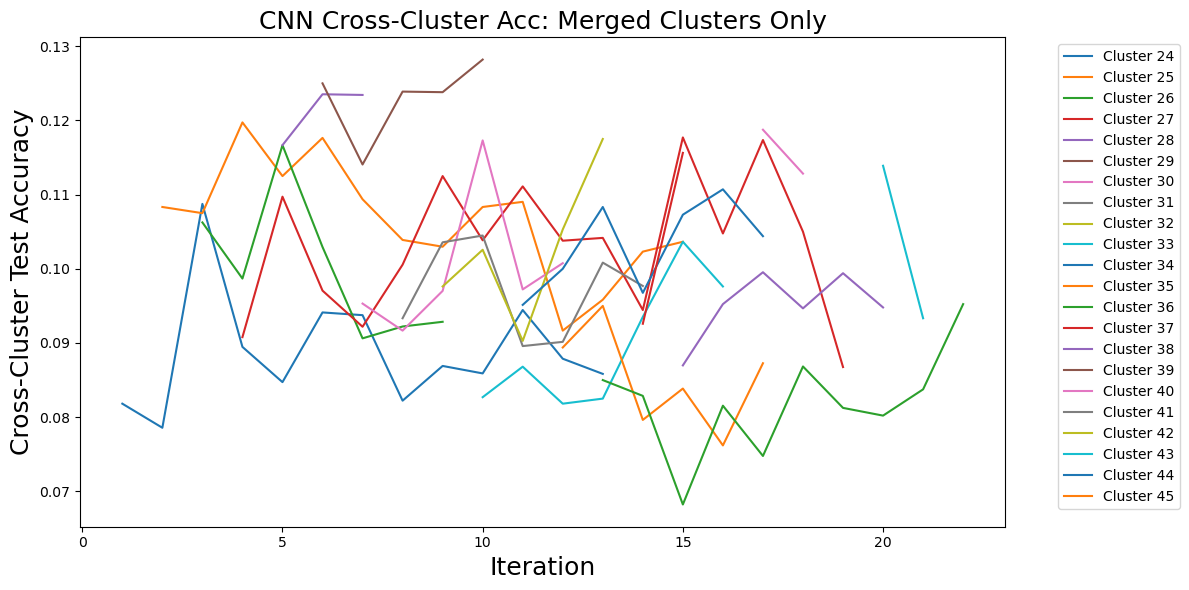

In [16]:
viz_merged_crosscluster_acc(cross_cluster_performance, model_str)

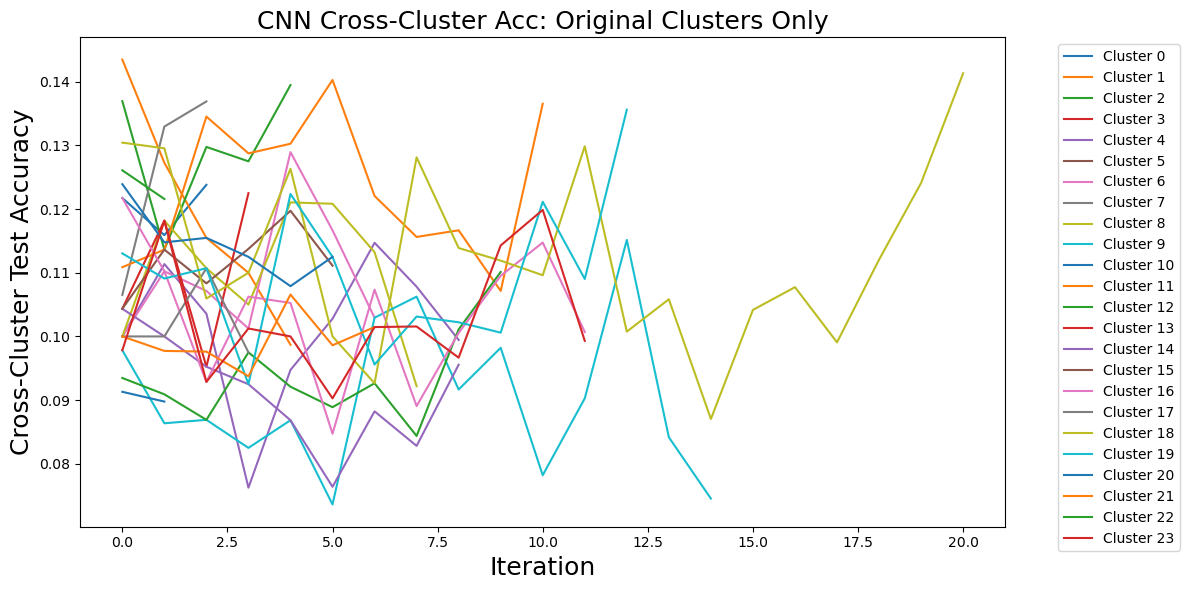

In [17]:
viz_orig_crosscluster_acc(cross_cluster_performance, model_str)

## Test Accuracy Merge Tracking

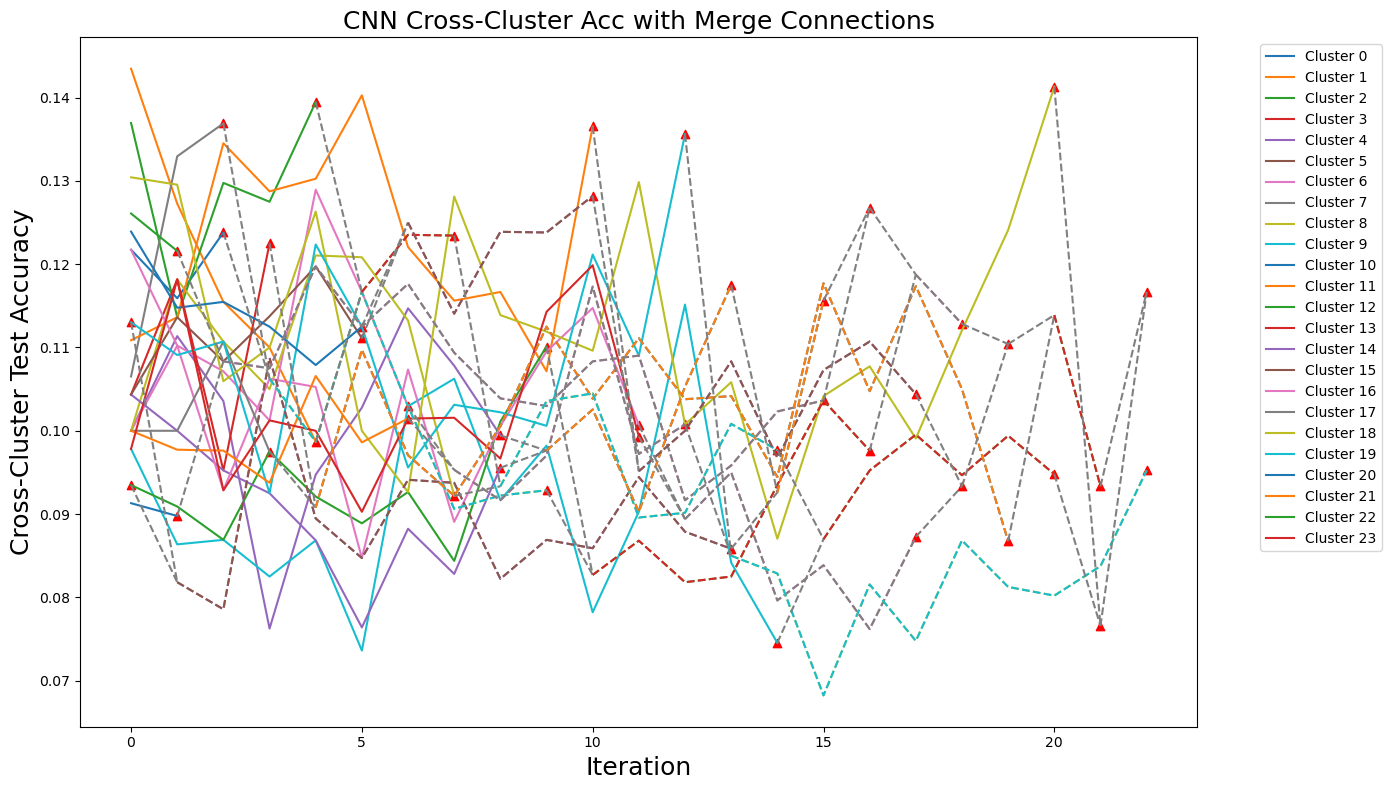

In [18]:
viz_crosscluster_acc_with_merges(cross_cluster_performance, merge_log, model_str)

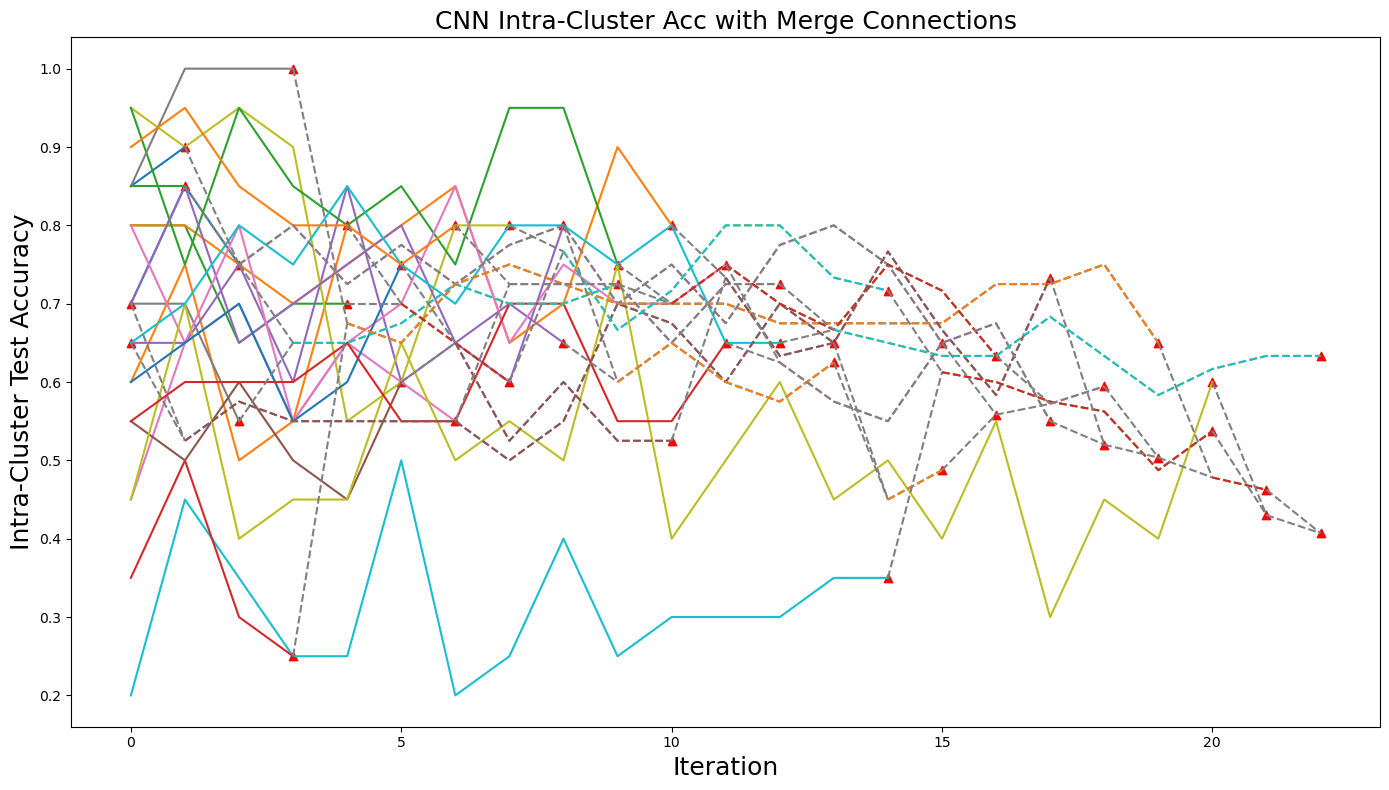

In [19]:
viz_intracluster_acc_with_merges(intra_cluster_performance, merge_log, model_str)

In [20]:
intra_mean_lst, cross_mean_lst, ratio_lst = compute_performance_ratios(intra_cluster_performance, cross_cluster_performance)



=== Performance Ratios ===
Cluster 0: Intra Mean = 0.767, Cross Mean = 0.120
Cluster 1: Intra Mean = 0.640, Cross Mean = 0.119
Cluster 2: Intra Mean = 0.730, Cross Mean = 0.129
Cluster 3: Intra Mean = 0.700, Cross Mean = 0.093
Cluster 4: Intra Mean = 0.683, Cross Mean = 0.101
Cluster 5: Intra Mean = 0.650, Cross Mean = 0.113
Cluster 6: Intra Mean = 0.593, Cross Mean = 0.110
Cluster 7: Intra Mean = 0.650, Cross Mean = 0.125
Cluster 8: Intra Mean = 0.806, Cross Mean = 0.110
Cluster 9: Intra Mean = 0.313, Cross Mean = 0.090
Cluster 10: Intra Mean = 0.875, Cross Mean = 0.091
Cluster 11: Intra Mean = 0.773, Cross Mean = 0.123
Cluster 12: Intra Mean = 0.855, Cross Mean = 0.094
Cluster 13: Intra Mean = 0.350, Cross Mean = 0.110
Cluster 14: Intra Mean = 0.717, Cross Mean = 0.091
Cluster 15: Intra Mean = 0.533, Cross Mean = 0.112
Cluster 16: Intra Mean = 0.713, Cross Mean = 0.104
Cluster 17: Intra Mean = 0.963, Cross Mean = 0.102
Cluster 18: Intra Mean = 0.502, Cross Mean = 0.113
Cluster 19: I

# Finetuning Process

In [21]:
# Fine-tune on first test participant's data
first_test_participant_data = data_splits['novel_trainFT']
# Select just the first given participant ID from this dataset, probably for both train_data and labels

participant_id = 'P132'
# Filter based on participant_id
indices = [i for i, pid in enumerate(first_test_participant_data['participant_ids']) if pid == participant_id]
# Extract the corresponding features and labels
features_p132 = [first_test_participant_data['feature'][i] for i in indices]
labels_p132 = [first_test_participant_data['labels'][i] for i in indices]


In [22]:
#nested_clus_model_dict

# So I don't have a single generic model anymore...
# Need to choose a specific iteration, or at least a specific cluster's model to use.......
## Idk how to do that in a principled way...
## Could try brute force, or could try doing some few-shot cluster assignment or something and then using that cluster model? ...

# Cluster 41 did pretty good:
#Cluster 41: Intra Mean = 0.624, Cross Mean = 0.108, Ratio = 5.791


In [23]:
nested_clus_model_dict.keys()

dict_keys(['Iter0', 'Iter1', 'Iter2', 'Iter3', 'Iter4', 'Iter5', 'Iter6', 'Iter7', 'Iter8', 'Iter9', 'Iter10', 'Iter11', 'Iter12', 'Iter13', 'Iter14', 'Iter15', 'Iter16', 'Iter17', 'Iter18', 'Iter19', 'Iter20', 'Iter21', 'Iter22'])

In [24]:
nested_clus_model_dict['Iter18'].keys()

dict_keys([18, 27, 36, 38, 40, 41])

In [25]:
clus41_model = nested_clus_model_dict['Iter18'][41]
clus41_model

CNNModel(
  (conv1): Conv1d(1, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): Identity()
  (conv2): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): Identity()
  (fc1): Linear(in_features=1280, out_features=128, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [26]:
# EVALUATION

# I would need to 
## 1) know which pids are in each cluster, at each merge iteration, 
## 2) bissect the datasets accordingly, 
## 3) create the trainloaders

# And idk from which merge iteration I would report the results from...
## Obv wouldnt want to show 30 iterations x 2-30 clusters per iter...

In [ ]:
# Create dataset and loader for fine-tuning
ft_132_dataset = GestureDataset(features_p132, labels_p132)
ft_132_loader = DataLoader(fine_tune_dataset, batch_size=16, shuffle=True)

In [27]:
fine_tuned_model = fine_tune_model(
    clus41_model, 
    ft_132_loader)

C:\Users\kdmen\Repos\fl-gestures\ELEC573_Proj\DNN_FT_funcs.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  self.features = torch.tensor(features, dtype=torch.float32)


In [28]:
# Uh do I have a separate testing set to evaluate this on the new user???

In [29]:
# Get the first test participant's data testing data (post FT)
first_test_participant_testset = data_splits['cross_subject_test']
indices = [i for i, pid in enumerate(first_test_participant_testset['participant_ids']) if pid == participant_id]
test_features_p132 = [first_test_participant_testset['feature'][i] for i in indices]
test_labels_p132 = [first_test_participant_testset['labels'][i] for i in indices]


In [30]:
len(test_features_p132)

70

In [31]:
len(test_labels_p132)

70

In [33]:
# WANT TO COMPARE THE MODEL PERFORMANCE ON THE NOVEL CLIENT PRE AND POST FT
## VARY AMOUNT OF FT: 
## 1) hyperparams (epoch, lr, weight decay, dropout, etc) and 
## 2) how much data from novel_trainFT is used

In [ ]:
#def evaluate_model(model, dataloader, criterion=nn.CrossEntropyLoss(), device=None):    
#    return {
#        'loss': total_loss / len(dataloader),
#        'accuracy': np.mean(np.array(all_preds) == np.array(all_labels)),
#        'predictions': all_preds,
#        'true_labels': all_labels
#    }

In [36]:
# Datasets and loaders
p132_dataset = GestureDataset(test_features_p132, test_labels_p132)
p132_loader = DataLoader(p132_dataset, batch_size=32, shuffle=True)


In [41]:
generic41_on_132_res = evaluate_model(clus41_model, p132_loader) 
print(generic41_on_132_res['accuracy'])

# Would also be interesting to see the distribution of pred labels vs true labels

0.07142857142857142


In [42]:
ft41_on_132_res = evaluate_model(fine_tuned_model, p132_loader) 
print(ft41_on_132_res['accuracy'])

# Would also be interesting to see the distribution of pred labels vs true labels

0.07142857142857142


In [ ]:
assert(False)

In [34]:
# NEED TO EVALUATE FINETUNED MODEL, at least on said user's data...

# Evaluation
train_results = evaluate_model(model, train_loader)
intra_test_results = evaluate_model(model, intra_test_loader)
cross_test_results = evaluate_model(model, cross_test_loader)

# Performance by participant and gesture
train_performance = gesture_performance_by_participant(
    train_results['predictions'], 
    train_results['true_labels'], 
    data_splits['train']['participant_ids'], 
    all_participants, 
    unique_gestures
)

intra_test_performance = gesture_performance_by_participant(
    intra_test_results['predictions'], 
    intra_test_results['true_labels'], 
    data_splits['intra_subject_test']['participant_ids'], 
    [participant for participant in all_participants if participant not in test_participants], 
    unique_gestures
)

cross_test_performance = gesture_performance_by_participant(
    cross_test_results['predictions'], 
    cross_test_results['true_labels'], 
    data_splits['cross_subject_test']['participant_ids'], 
    test_participants, 
    unique_gestures
)

return {
    'model': model,
    'train_performance': train_performance,
    'intra_test_performance': intra_test_performance,
    'cross_test_performance': cross_test_performance,
    'train_accuracy': train_results['accuracy'],
    'intra_test_accuracy': intra_test_results['accuracy'],
    'cross_test_accuracy': cross_test_results['accuracy']
}

# Example usage in main script
visualize_model_performance(results)

# Example usage in main script
log_file = log_performance(results)
print(f"Detailed performance log saved to: {log_file}")

NameError: name 'model' is not defined

# Logging
> Really ought to log results somehow...